In [22]:
import numpy as np
import sdeint
import csv
import matplotlib.pyplot as plt
import time
from abc_env import ABC_env
from naive_agents import DoNothing, FixedPhi
import plotly.graph_objects as go

In [23]:
# PARAMS
A = 1.
B = 0.7
C = 0.43
NU = 0.99
kappa = 0.001
BETA = 0.1
PHI = 0.9
D = 0.1 # placeholder for now
dims = 3
delta_t = 0.05
initial_sep=0.2*np.pi

In [24]:
D_tilde = (dims+2)*(dims-1)*D
(D_tilde + np.sqrt(4*BETA+D_tilde**2))/2

1.0916079783099617

In [25]:
D_tilde

1.0

In [26]:
#TODO sample proper values for lyapunov exponent
# decide if running inside environment or want more direct numerics (in julia or not)
    # in evironment is fine maybe nooooot
#

In [27]:
# trying doing direct with sdeint and see if that's faster

In [28]:
def f(u, t):
    swim_vector = u[0:3] - u[3:]
    return np.array([
        A*np.sin(u[2]) + C*np.cos(u[1]),
        B*np.sin(u[0]) + A*np.cos(u[2]),
        C*np.sin(u[1]) + B*np.cos(u[0]),
        A*np.sin(u[5]) + C*np.cos(u[4]) + PHI * swim_vector[0],
        B*np.sin(u[3]) + A*np.cos(u[5]) + PHI * swim_vector[1],
        C*np.sin(u[4]) + B*np.cos(u[3]) + PHI * swim_vector[2],
    ])

def g(u, t):
    return np.array([
        [np.sqrt(kappa), 0, 0, 0, 0, 0],
        [0, np.sqrt(kappa), 0, 0, 0, 0],
        [0, 0, np.sqrt(kappa), 0, 0, 0],
        [0, 0, 0, np.sqrt(kappa), 0, 0],
        [0, 0, 0, 0, np.sqrt(kappa), 0],
        [0, 0, 0, 0, 0, np.sqrt(kappa)],
    ])



def penalty(sep,phi,beta,delta_t):
    return (phi**2+beta)*sep**2*delta_t

In [29]:
def baseline(time_remaining,separation):
        """
        Returns the baseline aproximate for the given phi value and the current state

        NOTE: In training you should always evaluate for a fixed phi not the phi the agent picks. 

        """
        d_tilde = (dims+2) * (dims-1) * D
        #useful intermediate value used in the baseline mutiple times
        block = NU + 2*PHI - d_tilde
        a = ((BETA + PHI**2)*(1-np.exp(-time_remaining*block)))/block
        b_term1 = dims * kappa * (BETA + PHI**2) / (NU*(2*PHI-d_tilde))
        b_term2 = 1 - np.exp(-NU*time_remaining) - NU * (1-np.exp(-time_remaining*block))/block
        b = b_term1 * b_term2
        return (a*separation**2 + b)

In [43]:
# Run the SDEs
dictionary = {}
num_eps = 25000

t_end=10.0

start = time.time()


dictionary = {}
noise_initial = np.random.rand(6)-0.5
for i in range(num_eps):
    
    # set inital separation
    #noise_initial = np.random.rand(6)-0.5
    #sep_vec = noise_initial[:3] - noise_initial[3:]
    #sep_vec = sep_vec/np.linalg.norm(sep_vec)*initial_sep
    #noise_initial[3:] = noise_initial[3:]+sep_vec
    
    
    u0 = noise_initial


    tspan = np.arange(0.0, t_end,delta_t)  # 10 time units

    result = sdeint.itoint(f, g, u0, tspan)
    
    # storing last value for the random start of the next value in the uhlenbreck processes
    noise_initial = result[-1]

    sep_vecs = result[:,0:3]-result[:,3:]
    separations = np.sum(sep_vecs**2,axis=1)
    separations = np.sqrt(separations)


    N = len(separations)
    S_n = 0.0
    returns = np.zeros(N)
    discount = np.exp(-NU*delta_t)
    for i in range(1,N+1):
        S_n = S_n*discount + penalty(separations[N-i],PHI,BETA,delta_t)
        returns[N-i] = S_n
        
    
    delta_r = 0.002
    for i in range(N):
        key = (i, int(separations[i]/delta_r))
        if key in dictionary:
            # increase sum and count
            dictionary[key] = dictionary[key][0] + returns[i], dictionary[key][1] + 1
        else:
            dictionary[key] = [returns[i], 1]
            
            
end = time.time()
print(end - start)

755.3132934570312


In [ ]:
#TODO create a params dictionary and write/associate it with the file somehow

In [44]:
with open(f'baseline_CSVs/non_stationary_eps:{num_eps}_dt:{delta_t}_phi:{PHI}_end:{t_end}_dr:{delta_r}.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(dictionary.keys()))
    writer.writeheader()
    writer.writerow(dictionary)

In [45]:
t_end = max(tspan)
sampled = np.zeros([350,len(tspan)])
evaluated = np.zeros([350,len(tspan)])
count_threshhold = 100
for key, value in dictionary.items():
    if value[1] > count_threshhold:
        time_remaining = t_end - key[0]*delta_t
        sep = key[1]*delta_r
        sampled[key[1]][key[0]] = value[0]/value[1]
        evaluated[key[1]][key[0]] = baseline(time_remaining,sep)

(0.0, 0.12)

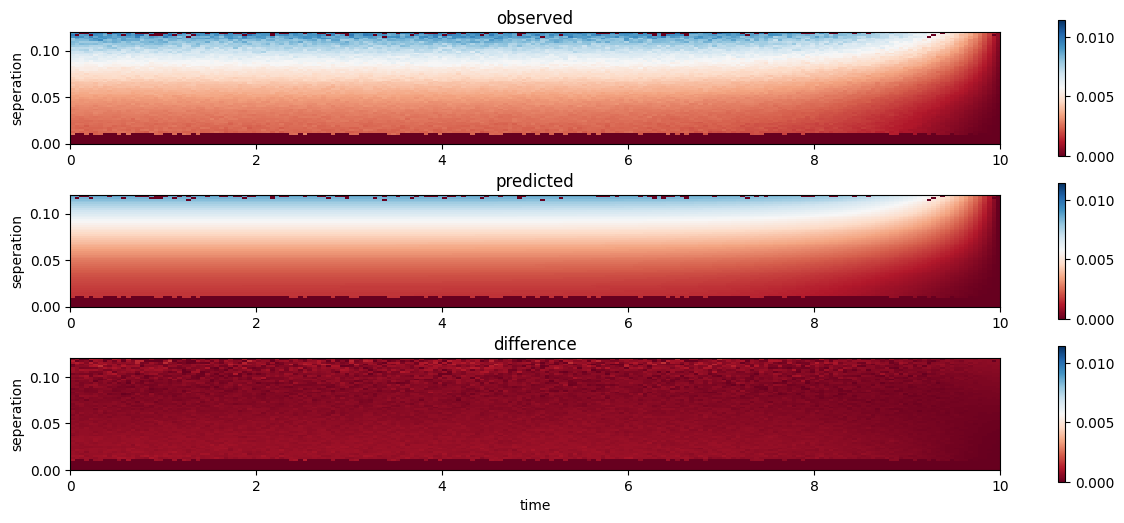

In [47]:

cmap="RdBu"
fig, ax = plt.subplots(3, 1)
minmin = 0.
maxmax = max(sampled.max(),evaluated.max())


scale = ax[0].imshow(np.flip(sampled,axis=0),vmin=minmin, vmax=maxmax, interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
scale2 = ax[1].imshow(np.flip(evaluated,axis=0),vmin=minmin, vmax=maxmax, interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
scale3 = ax[2].imshow(abs(np.flip((evaluated-sampled),axis=0)),vmin=minmin, vmax=maxmax, interpolation='nearest', extent = [0 , sampled.shape[1]*delta_t,0,delta_r*sampled.shape[0]], aspect=10,cmap=cmap)
fig.set_size_inches(15,6)
fig.colorbar(scale, ax=ax[0])
fig.colorbar(scale2, ax=ax[1])
fig.colorbar(scale3, ax=ax[2])

ax[0].set_xlabel('')
ax[0].set_ylabel('seperation')
ax[0].set_title("observed")
ax[0].set_ylim(0,0.12)

ax[1].set_xlabel('')
ax[1].set_ylabel('seperation')
ax[1].set_title("predicted")
ax[1].set_ylim(0,0.12)

ax[2].set_xlabel('time')
ax[2].set_ylabel('seperation')
ax[2].set_title("difference")
ax[2].set_ylim(0,0.12)

In [13]:
assert(1==0)

AssertionError: 

In [ ]:
dictionary

In [ ]:
result.shape

In [ ]:
separations

In [ ]:
x=[1,2,3]
x[-3]

In [ ]:
sep_vecs = result[:,0:3]-result[:,3:]

In [ ]:
np.sum(sep_vecs**2,axis=1)

In [ ]:
tspan = np.arange(0.0, 100.0,delta_t)  # 10 time units
result = sdeint.itoint(f, g, np.random.rand(6), tspan)

In [ ]:
fig = go.Figure(data=go.Scatter3d(
        x=result[:,0],
        y=result[:,1],
        z=result[:,2],
        mode='lines',
        name = "passive trajectory"
      )
    )

fig.add_trace(go.Scatter3d(
    x=result[:,3],
    y=result[:,4],
    z=result[:,5],
    mode='lines',
    name="Active trajectory"
))